In [1]:
# PROJECT/IMPLEMENTATION IDEAS
# 1. Historical market cap, % bitcoin (requires crawling https://coinmarketcap.com/historical/)
# 2. Twitter sentiment analysis of Bitcoin vs price
# 3. Bitcoin vs. altcoin market caps
# 4. Transaction fees, user/address count(?), other features(?) vs bitcoin price
# 5. Usage by country
# 6. Bitcoin trading by exchange
# 7. Bitcoin trading by currency
# 8. Increase in leverage?

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from pandas.core import datetools
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import dateutil.parser
from pprint import pprint
import warnings; warnings.simplefilter('ignore')
import json
import time
import sys
import re
import datetime

# APIs
# import quandl
# import coinmarketcap

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Helper functions
def to_currency(int):
    return "${:,.0f}".format(int//1000000)

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def list_to_average(list):
    try:
        avg = list[0]/list[1]
    except:
        avg = 0
    return avg

# def none_to_value(num):
#     if num == None:
#         num = 


In [4]:
df = pd.read_pickle('data/benson_btcsentiment_df.pkl')
df = df[['logBTCPrice','logETHPrice','logBTCVol','logTxFees','logCostperTxn','logNoTxns','logAvgBlkSz','logUniqueAddresses','logHashRate','logCrypto Market Cap','logNasdaq','logGold','logInterest','DateNum','Quarter','Month','Weekday']]
df_all = df
df_hist = df
df.head()

,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,DateNum,Quarter,Month,Weekday
2016-07-13,6.487181,2.356126,13.677656,10.454313,1.738710,12.296982,-0.261365,12.847761,14.232219,23.229166,8.518339,5.425787,1.098612,32.0,3.0,7.0,2.0
2016-07-14,6.486362,2.350422,13.679501,10.469753,1.621366,12.292677,-0.210721,12.813804,14.136909,23.229166,8.523982,5.424421,1.098612,33.0,3.0,7.0,3.0
2016-07-15,6.498043,2.442347,13.536535,10.561370,1.702928,12.304356,-0.235722,12.815710,14.225202,23.229166,8.523094,5.411646,1.098612,34.0,3.0,7.0,4.0
2016-07-17,6.498043,2.442347,13.536535,10.561370,1.702928,12.304356,-0.235722,12.815710,14.225202,23.279152,8.523094,5.411646,1.098612,34.0,3.0,7.0,4.0
2016-07-18,6.522313,2.429218,13.531194,10.390760,2.026832,12.049495,-0.356675,12.707847,14.273321,23.279152,8.528287,5.413564,1.098612,35.0,3.0,7.0,0.0


In [5]:
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logETHPrice,logBTCVol,logTxFees,logCostperTxn,logNoTxns,logAvgBlkSz,logUniqueAddresses,logHashRate,logCrypto Market Cap,logNasdaq,logGold,logInterest,DateNum,Quarter,Month,Weekday
logBTCVol,-0.430896,-0.567610,1.000000,-0.469885,-0.458770,0.005546,-0.238398,-0.205987,-0.487301,-0.471091,-0.538804,-0.139854,-0.388334,-0.489742,0.316931,0.314857,0.058673
logGold,-0.299268,-0.233826,-0.139854,-0.346721,-0.248834,-0.385720,-0.373675,-0.430833,-0.347355,-0.270742,-0.348564,1.000000,-0.331562,-0.418022,-0.105787,-0.134664,-0.004427
Weekday,-0.014358,-0.014698,0.058673,0.038238,-0.059315,0.311600,0.194801,0.158523,-0.015861,-0.014781,-0.017792,-0.004427,-0.011309,-0.012398,-0.013391,0.002803,1.000000
Month,0.077105,0.021796,0.314857,-0.054246,0.064864,-0.055776,-0.173354,-0.006768,-0.035280,0.034229,-0.087328,-0.134664,0.050376,-0.011534,0.972376,1.000000,0.002803
Quarter,0.077615,0.022863,0.316931,-0.070927,0.067536,-0.084940,-0.173644,-0.030540,-0.028577,0.037171,-0.086124,-0.105787,0.041187,-0.009799,1.000000,0.972376,-0.013391
logNoTxns,0.413106,0.263183,0.005546,0.499913,0.302813,1.000000,0.640947,0.862672,0.419546,0.346828,0.392307,-0.385720,0.458870,0.395988,-0.084940,-0.055776,0.311600
logAvgBlkSz,0.578058,0.501857,-0.238398,0.681140,0.490454,0.640947,1.000000,0.704613,0.545952,0.550349,0.596636,-0.373675,0.599898,0.587721,-0.173644,-0.173354,0.194801
logUniqueAddresses,0.772734,0.649989,-0.205987,0.823333,0.697573,0.862672,0.704613,1.000000,0.763077,0.725954,0.744436,-0.430833,0.791106,0.748349,-0.030540,-0.006768,0.158523
logETHPrice,0.936329,1.000000,-0.567610,0.924793,0.949459,0.263183,0.501857,0.649989,0.928562,0.970192,0.942408,-0.233826,0.911639,0.937393,0.022863,0.021796,-0.014698
logNasdaq,0.958056,0.942408,-0.538804,0.949428,0.952542,0.392307,0.596636,0.744436,0.981946,0.964166,1.000000,-0.348564,0.941753,0.985440,-0.086124,-0.087328,-0.017792


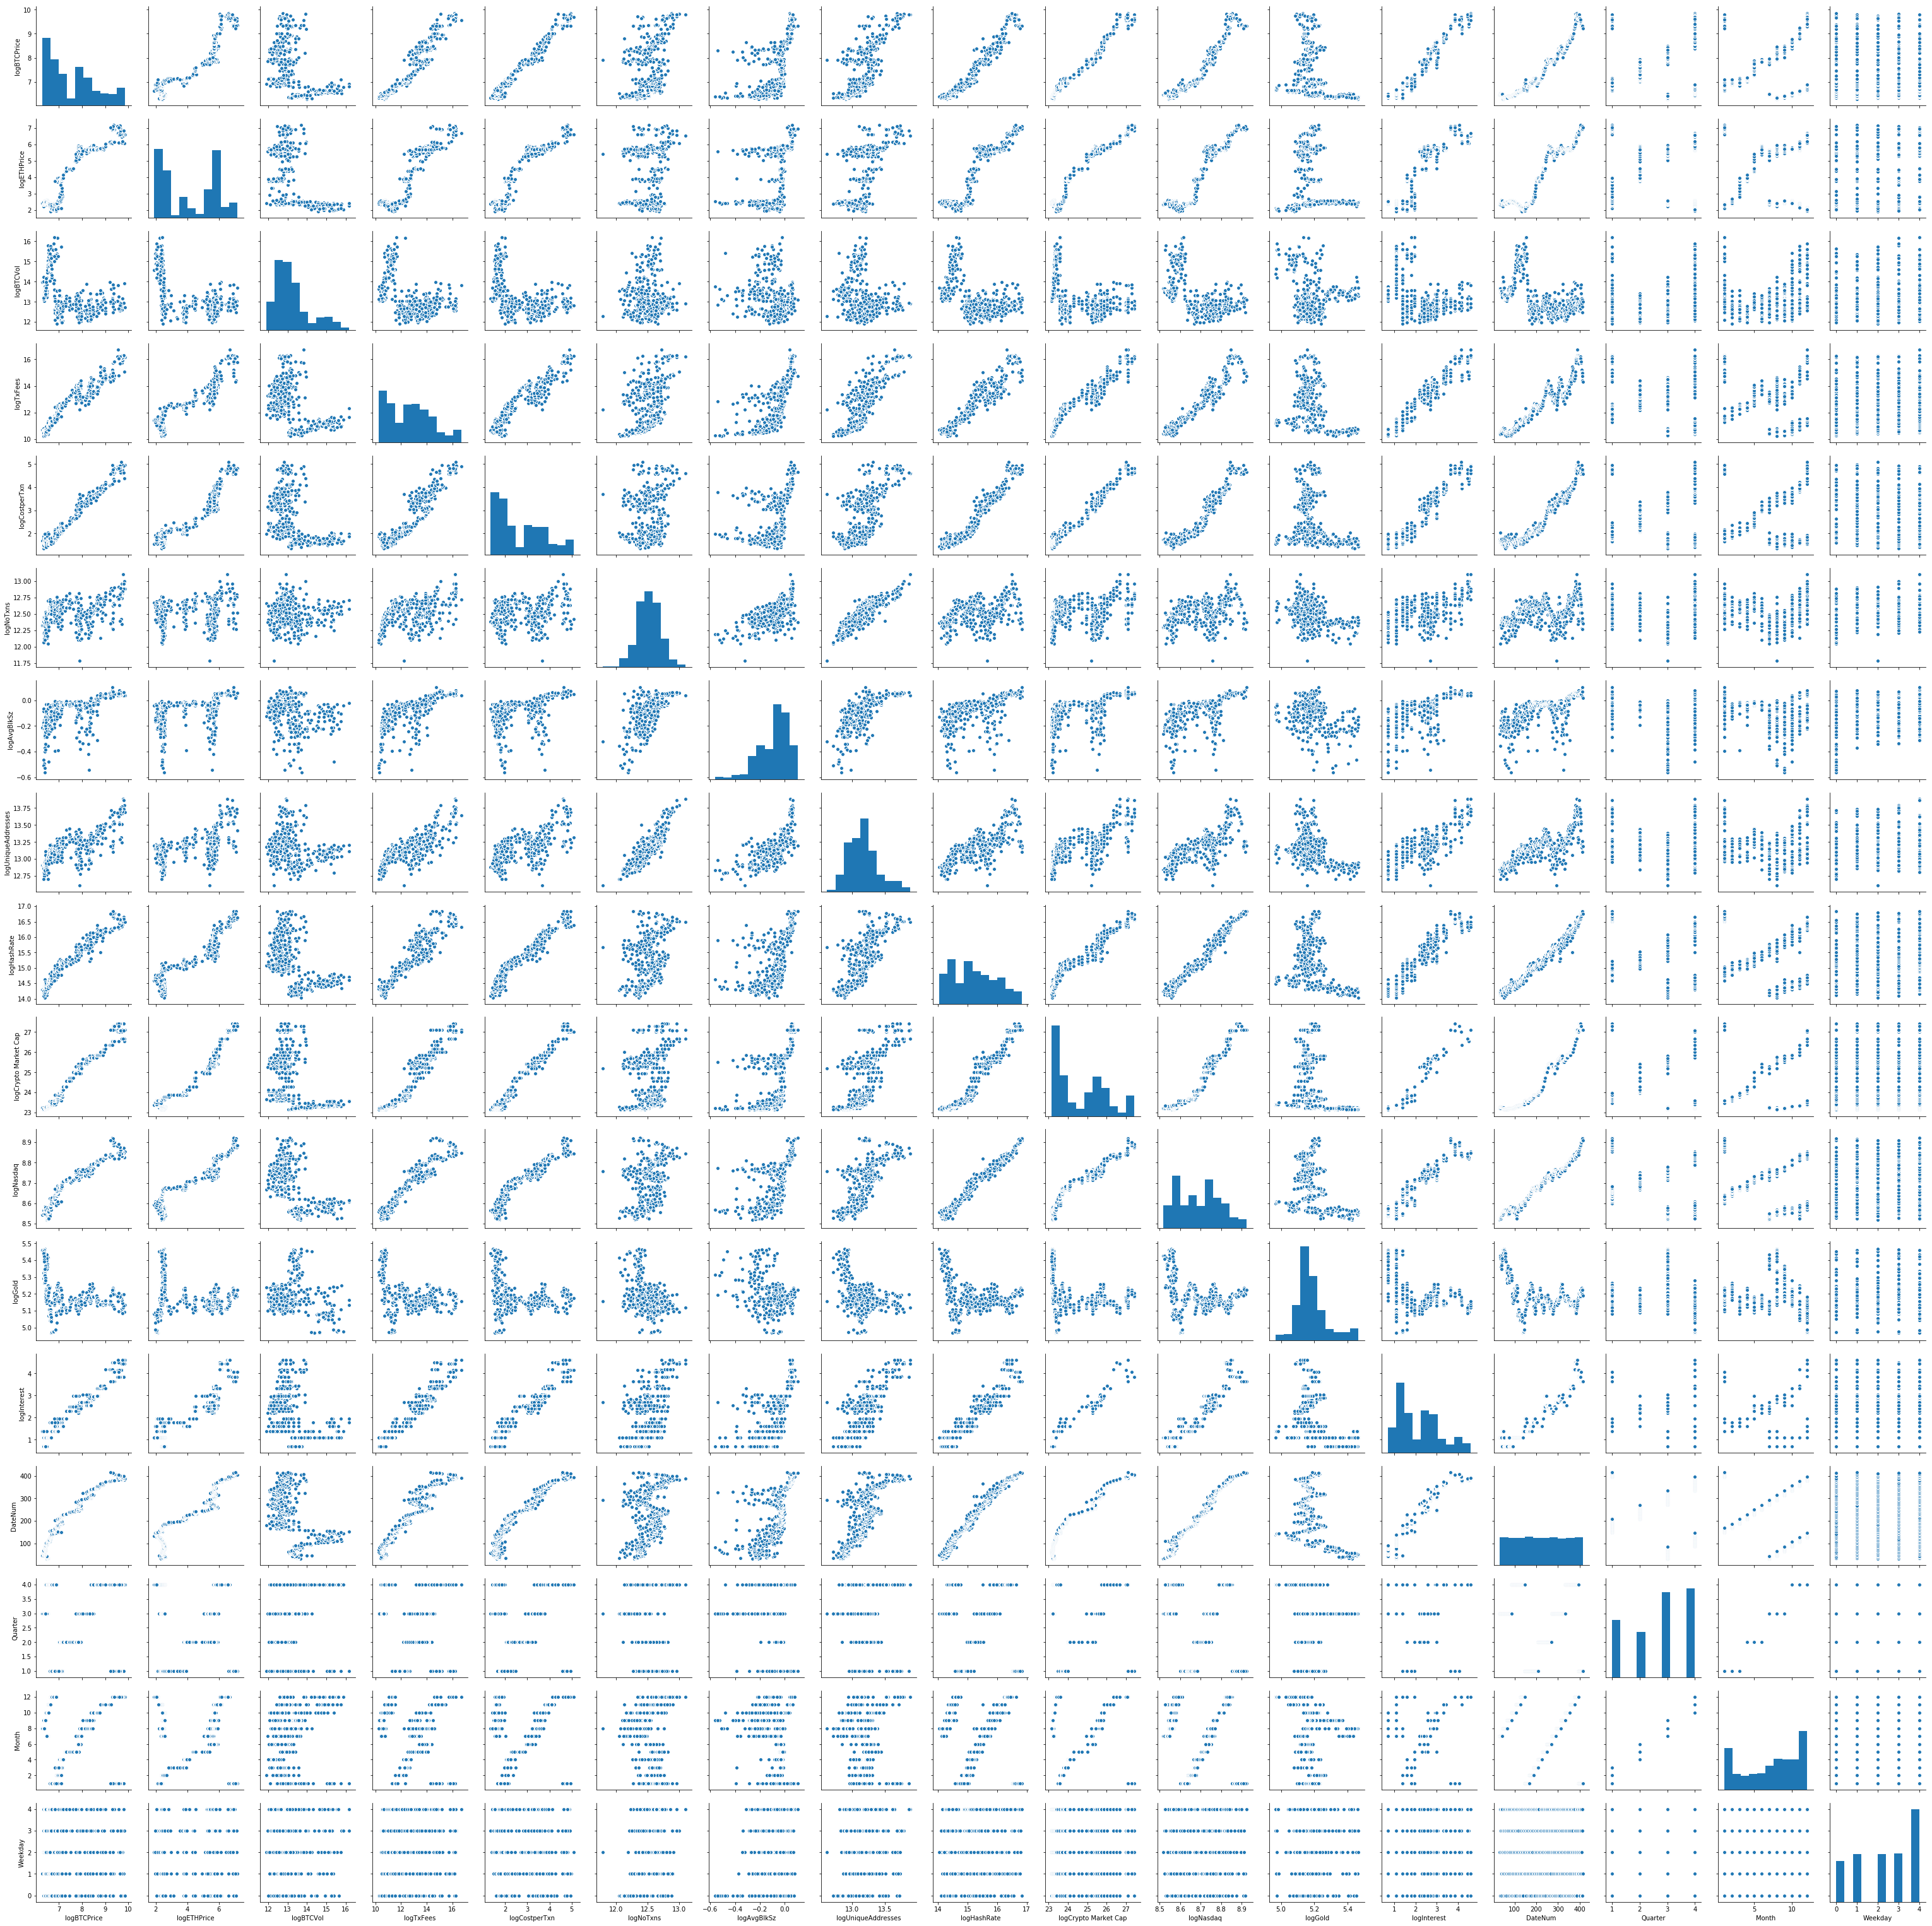

In [6]:
sns.pairplot(df_all)

In [7]:
# MAIN MODEL
# Reducing to few key features
df_all = df_all[['logBTCPrice','logNasdaq','logInterest','logTxFees','Month']]
df_all.corr().sort_values('logBTCPrice')

,logBTCPrice,logNasdaq,logInterest,logTxFees,Month
Month,0.077105,-0.087328,0.050376,-0.054246,1.000000
logNasdaq,0.958056,1.000000,0.941753,0.949428,-0.087328
logTxFees,0.958599,0.949428,0.953378,1.000000,-0.054246
logInterest,0.977008,0.941753,1.000000,0.953378,0.050376
logBTCPrice,1.000000,0.958056,0.977008,0.958599,0.077105


'\nPossible leading indicators:\nGoogle Search Interest\n\n\nFollowing Indicators:\nCost per Transaction\nCrypto Market Cap\nEthereum Price\n'

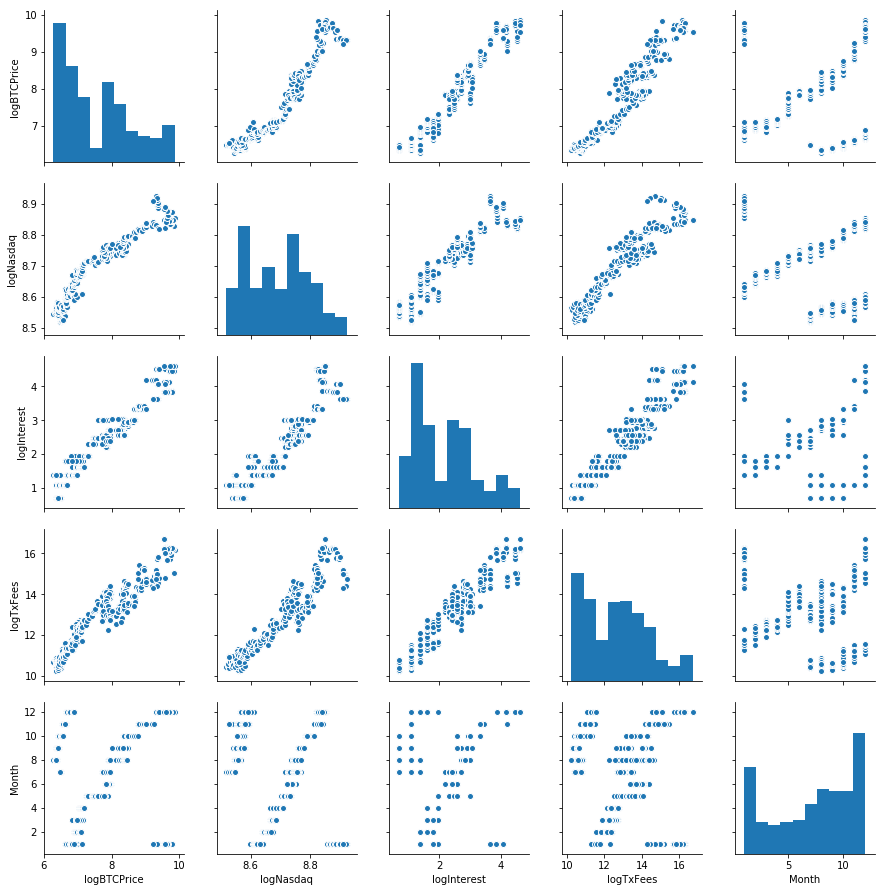

In [8]:
sns.pairplot(df_all)
'''
Possible leading indicators:
Google Search Interest


Following Indicators:
Cost per Transaction
Crypto Market Cap
Ethereum Price
'''

In [9]:
df = df_all
# STATSMODELS
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('logBTCPrice ~ logInterest + logNasdaq + logTxFees + Month', data=df, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     4749.
Date:                Wed, 31 Jan 2018   Prob (F-statistic):               0.00
Time:                        14:32:27   Log-Likelihood:                 198.60
No. Observations:                 464   AIC:                            -387.2
Df Residuals:                     459   BIC:                            -366.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -26.1580      2.117    -12.356      0.000     -30.318     -21.998
logInterest     0.4342      0.028     15.514      0.000       0.379       0.489
logNasdaq       3.5627      0.257     13.888      0.000       3.059       4.067
logTxFees       0.1278      0.018      7.298      0.000       0.093       0.162
Month           0.0285      0.002     12.235      0.000       0.024       0.033
==============================================================================
Omnibus:                       13.273   Durbin-Watson:                   0.244
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.329
Skew:                           0.254   Prob(JB):                     0.000105
Kurtosis:                       3.831   Cond. No.                     5.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = df[['logInterest','logNasdaq','logTxFees','Month']]
# Choose the response variable(s)
y = df['logBTCPrice']
# Fit the model to the full dataset
lr.fit(X,y)
# Print out the R^2 for the model against the full dataset
print(lr.score(X,y))
print(lr.intercept_)
print(lr.coef_)

0.9764075218163337
-26.157971163273544
[0.43421752 3.56268932 0.12775366 0.02845491]


In [11]:
# def diagnostic_plot(x, y):
#     plt.figure(figsize=(20,5))
    
#     rgr = LinearRegression()
#     rgr.fit(x,y)
#     pred = rgr.predict(x)

#     plt.subplot(1, 3, 1)
#     plt.scatter(x,y)
#     plt.plot(x, pred, color='blue',linewidth=1)
#     plt.title("Regression fit")
#     plt.xlabel("x")
#     plt.ylabel("y")
    
#     plt.subplot(1, 3, 2)
#     res = y - pred
#     plt.scatter(pred, res)
#     plt.title("Residual plot")
#     plt.xlabel("prediction")
#     plt.ylabel("residuals")
    
#     plt.subplot(1, 3, 3)
#     #Generates a probability plot of sample data against the quantiles of a 
#     # specified theoretical distribution 
#     stats.probplot(res, dist="norm", plot=plt)
#     plt.title("Normal Q-Q plot")

# print(X.shape)
# print(y.shape)
# diagnostic_plot(X,y)

# Histogram of residuals

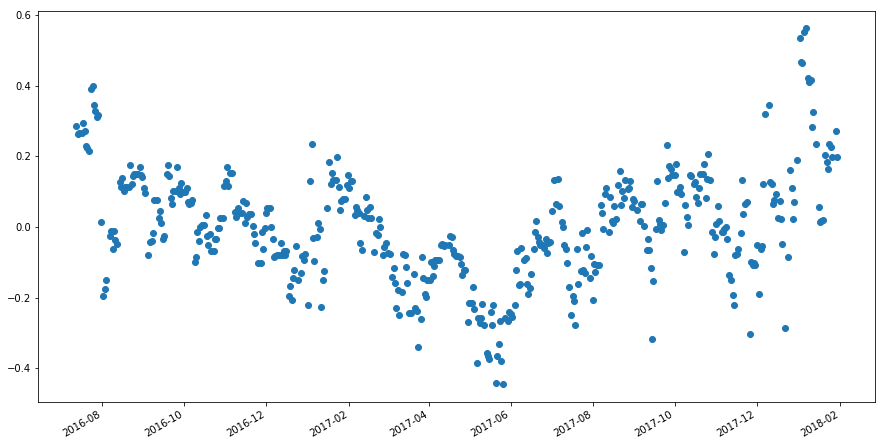

In [12]:
# Use statsmodels to plot the residuals
# NOTE THAT THIS IS A BAD FIT AS RESIDUALS ARE NOT RANDOM; NONLINEAR REGRESSION MAY BE REQUIRED
fit.resid.plot(style='o', figsize=(15,8));

(array([0.08555739, 0.25667216, 0.17111478, 0.6844591 , 1.02668865,
        1.11224604, 1.58281168, 3.03728727, 2.52394294, 2.31004947,
        2.18171339, 2.60950033, 0.85557388, 0.34222955, 0.34222955,
        0.29945086, 0.12833608, 0.08555739, 0.08555739, 0.12833608]),
 array([-0.44557439, -0.39519482, -0.34481524, -0.29443567, -0.24405609,
        -0.19367652, -0.14329694, -0.09291737, -0.04253779,  0.00784178,
         0.05822136,  0.10860093,  0.1589805 ,  0.20936008,  0.25973965,
         0.31011923,  0.3604988 ,  0.41087838,  0.46125795,  0.51163753,
         0.5620171 ]),
 <a list of 20 Patch objects>)

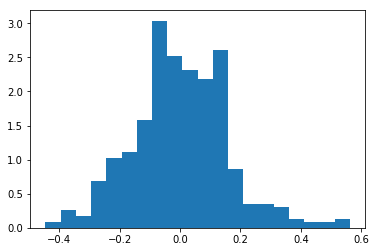

In [13]:
y_pred = lr.predict(X)

residuals = y - y_pred
plt.hist(residuals, bins = 20, normed=True)

In [14]:
# The cross validation for a time series would be as follows:
# split = int(round(len(df) * 0.9,0))
# X_train, X_test, y_train, y_test = df.iloc[:split,1:], df.iloc[split:,1:],df.iloc[:split,0],df.iloc[split:,0]
# Due to project requirements, I am using the standard linear regression train-test split for this analysis.

In [15]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size = 0.7)

# Fit the model against the training data
lr.fit(X_train, y_train)
# # Evaluate the model against the testing data
lr.score(X_test, y_test)

0.9716412379641812

In [16]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.978211850353708
0.9716412379641812


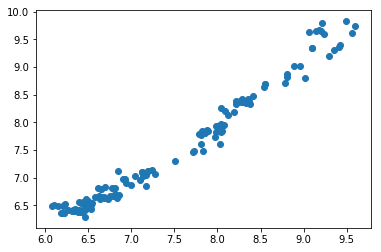

In [17]:
# chart prediction vs actual
plt.scatter(lr.predict(X_test), y_test)

Text(0,0.5,'Predicted')

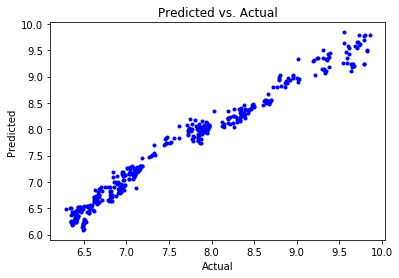

In [18]:

plt.plot(y, y_pred,'b.')
plt.title('Predicted vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [19]:
model1 = sm.OLS(y_train, X_train, missing ='drop')
fit1 = model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.477e+05
Date:                Wed, 31 Jan 2018   Prob (F-statistic):               0.00
Time:                        14:32:29   Log-Likelihood:                 98.434
No. Observations:                 324   AIC:                            -188.9
Df Residuals:                     320   BIC:                            -173.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
logInterest     0.6263      0.033     19.045      0.000       0.562       0.691
logNasdaq       0.4230      0.026     16.071      0.000       0.371       0.475
logTxFees       0.1896      0.023      8.408      0.000       0.145       0.234
Month           0.0196      0.003      6.575      0.000       0.014       0.026
==============================================================================
Omnibus:                        4.735   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                5.586
Skew:                          -0.125   Prob(JB):                       0.0612
Kurtosis:                       3.593   Cond. No.                         81.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
y_pred = fit1.predict(X_test)

Text(0,0.5,'Predicted y value')

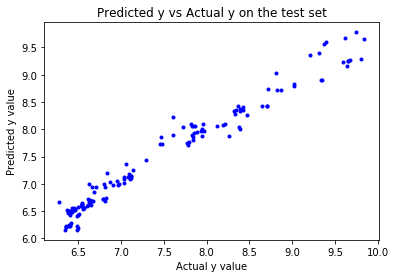

In [21]:
plt.plot(y_test, y_pred, 'b.')
plt.title('Predicted y vs Actual y on the test set')
plt.xlabel('Actual y value')
plt.ylabel('Predicted y value')

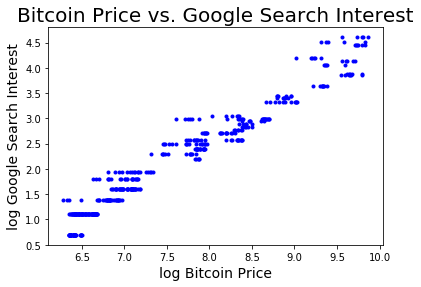

In [22]:
x = df['logBTCPrice']
y = df['logInterest']

plt.plot(x,y,'b.')
plt.title('Bitcoin Price vs. Google Search Interest',fontsize=20)
plt.xlabel('log Bitcoin Price',fontsize=14)
plt.ylabel('log Google Search Interest',fontsize=14)
plt.savefig('charts/interestvsbtcprice.png')

In [23]:
y, X = patsy.dmatrices('logBTCPrice ~ logInterest', data=df, return_type="dataframe")

# Create your model
model2 = sm.OLS(y,X)
# Fit your model to your training set
fit2 = model2.fit()
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     9702.
Date:                Wed, 31 Jan 2018   Prob (F-statistic):          3.03e-312
Time:                        14:32:30   Log-Likelihood:                 46.453
No. Observations:                 464   AIC:                            -88.91
Df Residuals:                     462   BIC:                            -80.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.5056      0.023    236.864      0.000       5.460       5.551
logInterest     0.9646      0.010     98.498      0.000       0.945       0.984
==============================================================================
Omnibus:                       22.947   Durbin-Watson:                   0.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.602
Skew:                          -0.510   Prob(JB):                     2.76e-06
Kurtosis:                       3.531   Cond. No.                         6.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

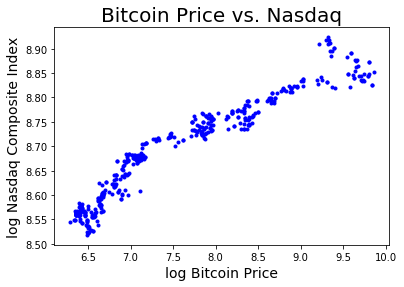

In [24]:
x = df['logBTCPrice']
y = df['logNasdaq']

plt.plot(x,y,'b.')
plt.title('Bitcoin Price vs. Nasdaq',fontsize=20)
plt.xlabel('log Bitcoin Price',fontsize=14)
plt.ylabel('log Nasdaq Composite Index',fontsize=14)
plt.savefig('charts/nasdaqvsbtcprice.png')

In [25]:
y, X = patsy.dmatrices('logBTCPrice ~ logNasdaq', data=df, return_type="dataframe")

# Create your model
model3 = sm.OLS(y,X)
# Fit your model to your training set
fit3 = model3.fit()
# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logBTCPrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     5163.
Date:                Wed, 31 Jan 2018   Prob (F-statistic):          6.87e-253
Time:                        14:32:30   Log-Likelihood:                -90.792
No. Observations:                 464   AIC:                             185.6
Df Residuals:                     462   BIC:                             193.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -75.2231      1.152    -65.286      0.000     -77.487     -72.959
logNasdaq      9.5245      0.133     71.856      0.000       9.264       9.785
==============================================================================
Omnibus:                       22.490   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.394
Skew:                           0.540   Prob(JB):                     5.05e-06
Kurtosis:                       3.309   Cond. No.                         741.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# Resources
# https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/
# http://cs229.stanford.edu/proj2015/029_report.pdf
# http://text-processing.com/ API
# https://trends.google.com/trends/explore?q=bitcoin,ethereum